In [5]:
from tkinter import filedialog
from tkinter import Tk
import numpy as np
import pandas as pd
import umap
from sklearn.preprocessing import LabelEncoder
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KernelDensity
from scipy.spatial import ConvexHull, Delaunay
import shap
import xgboost as xgb
import alphashape

root = Tk()
root.withdraw()

# read data
csv_file_path = filedialog.askopenfilename(title="Select Test-Data file", filetypes=(("CSV files", "*.csv"), ("All files", "*.*")))
Setting_File_path = filedialog.askopenfilename(title="Select Setting-file", filetypes=(("Excel files", "*.xlsx"), ("All files", "*.*")))

# df define
df = pd.read_csv(csv_file_path)
df_setting = pd.read_excel(Setting_File_path)

feature_vars = df_setting.loc[df_setting['Analysis_List'].notna(), 'Analysis_List'].tolist()
target_variable = df_setting.loc[df_setting['Target_Variable'].notna(), 'Target_Variable'].values[0]

# mode check @ test-Data
mode_data = df["Mode"]
unique_modes = mode_data.drop_duplicates().tolist()
print("Unique Modes:", unique_modes)

# data define
target_mode = "2wfF4"
train_df = df[df['Mode'] != target_mode]
test_df = df[df['Mode'] == target_mode]

train_data = train_df[feature_vars]
test_data = test_df[feature_vars]
target_data = train_df[target_variable]


# Unique Modes: ['USHWY', 'JC08', 'LA4', 'US06', '2WFf3kai', '2wfF4', 'VHmn', '2FJ']

Unique Modes: ['USHWY', 'JC08', 'LA4', 'US06', '2WFf3kai', '2wfF4', 'VHmn', '2FJ']


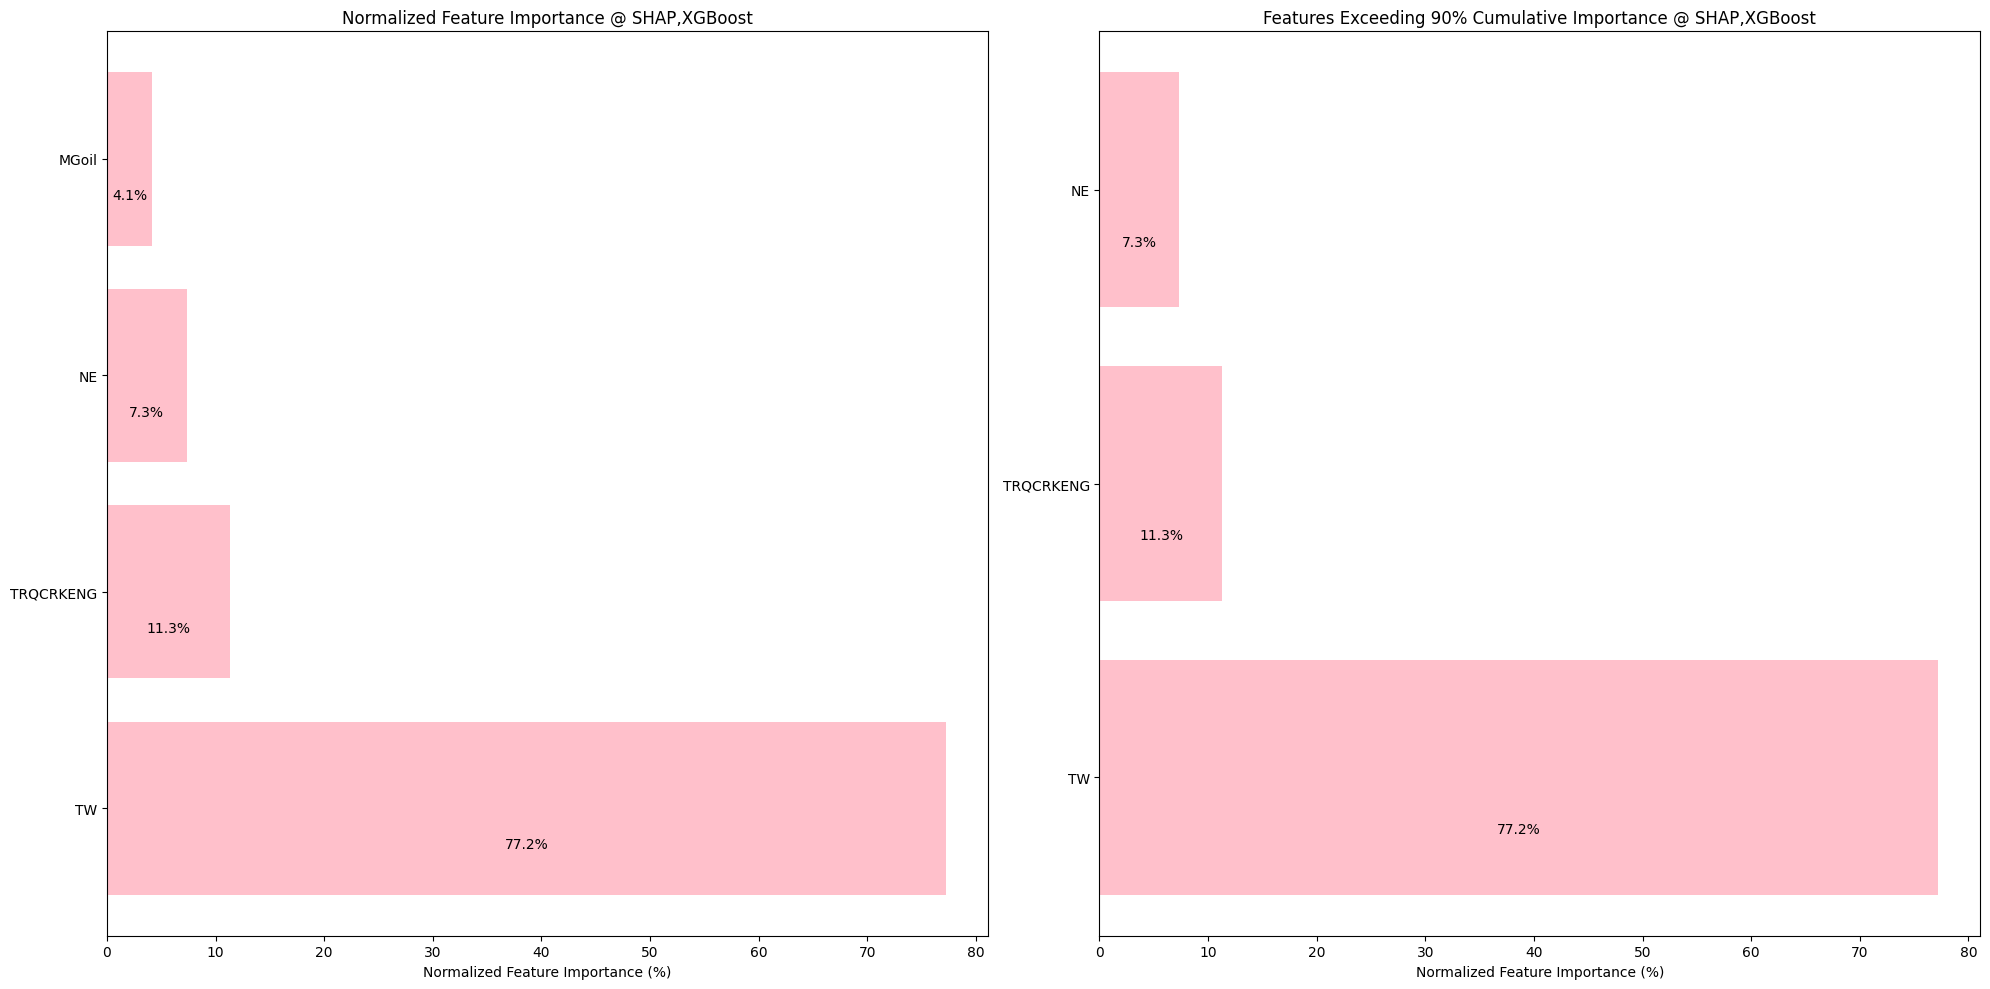

In [6]:
# モデル訓練
model = xgb.XGBRegressor(n_jobs=-1)
model.fit(train_data, target_data)

# SHAP値の計算
explainer = shap.Explainer(model)
shap_values = explainer(train_data)

# 特徴量の重要度とソート
feature_importance = np.abs(shap_values.values).mean(axis=0)
sorted_idx = np.argsort(-feature_importance)
sorted_importance = feature_importance[sorted_idx]

# 正規化
normalized_importance = (sorted_importance / np.sum(sorted_importance)) * 100

# 累計寄与度が90%を超えるまでの特徴量を選択
cumulative_importance = np.cumsum(sorted_importance / np.sum(sorted_importance))
selected_features_idx = np.where(cumulative_importance > 0.9)[0][0]
selected_features = [feature_vars[sorted_idx[i]] for i in range(selected_features_idx + 1)]
selected_normalized_importance = normalized_importance[:selected_features_idx + 1]

# 1行2列でプロット
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# すべての特徴量を表示
axes[0].barh(range(len(sorted_idx)), normalized_importance, align='center', color='pink')
axes[0].set_yticks(range(len(sorted_idx)))
axes[0].set_yticklabels([feature_vars[i] for i in sorted_idx])
axes[0].set_xlabel('Normalized Feature Importance (%)')
axes[0].set_title('Normalized Feature Importance @ SHAP,XGBoost')

bars = axes[0].patches
for bar in bars:
    axes[0].text(bar.get_width() * 0.5, bar.get_y() + bar.get_height()/4,
                f"{bar.get_width():.1f}%", color="black", fontsize=10, ha='center', va='bottom')

# 累計寄与度が90%を超える特徴量だけを表示
axes[1].barh(range(len(selected_features)), selected_normalized_importance, align='center', color='pink')
axes[1].set_yticks(range(len(selected_features)))
axes[1].set_yticklabels([feature_vars[sorted_idx[i]] for i in range(selected_features_idx + 1)])
axes[1].set_xlabel('Normalized Feature Importance (%)')
axes[1].set_title('Features Exceeding 90% Cumulative Importance @ SHAP,XGBoost')

bars = axes[1].patches
for bar in bars:
    axes[1].text(bar.get_width() * 0.5, bar.get_y() + bar.get_height()/4,
                f"{bar.get_width():.1f}%", color="black", fontsize=10, ha='center', va='bottom')

plt.tight_layout()
plt.show()


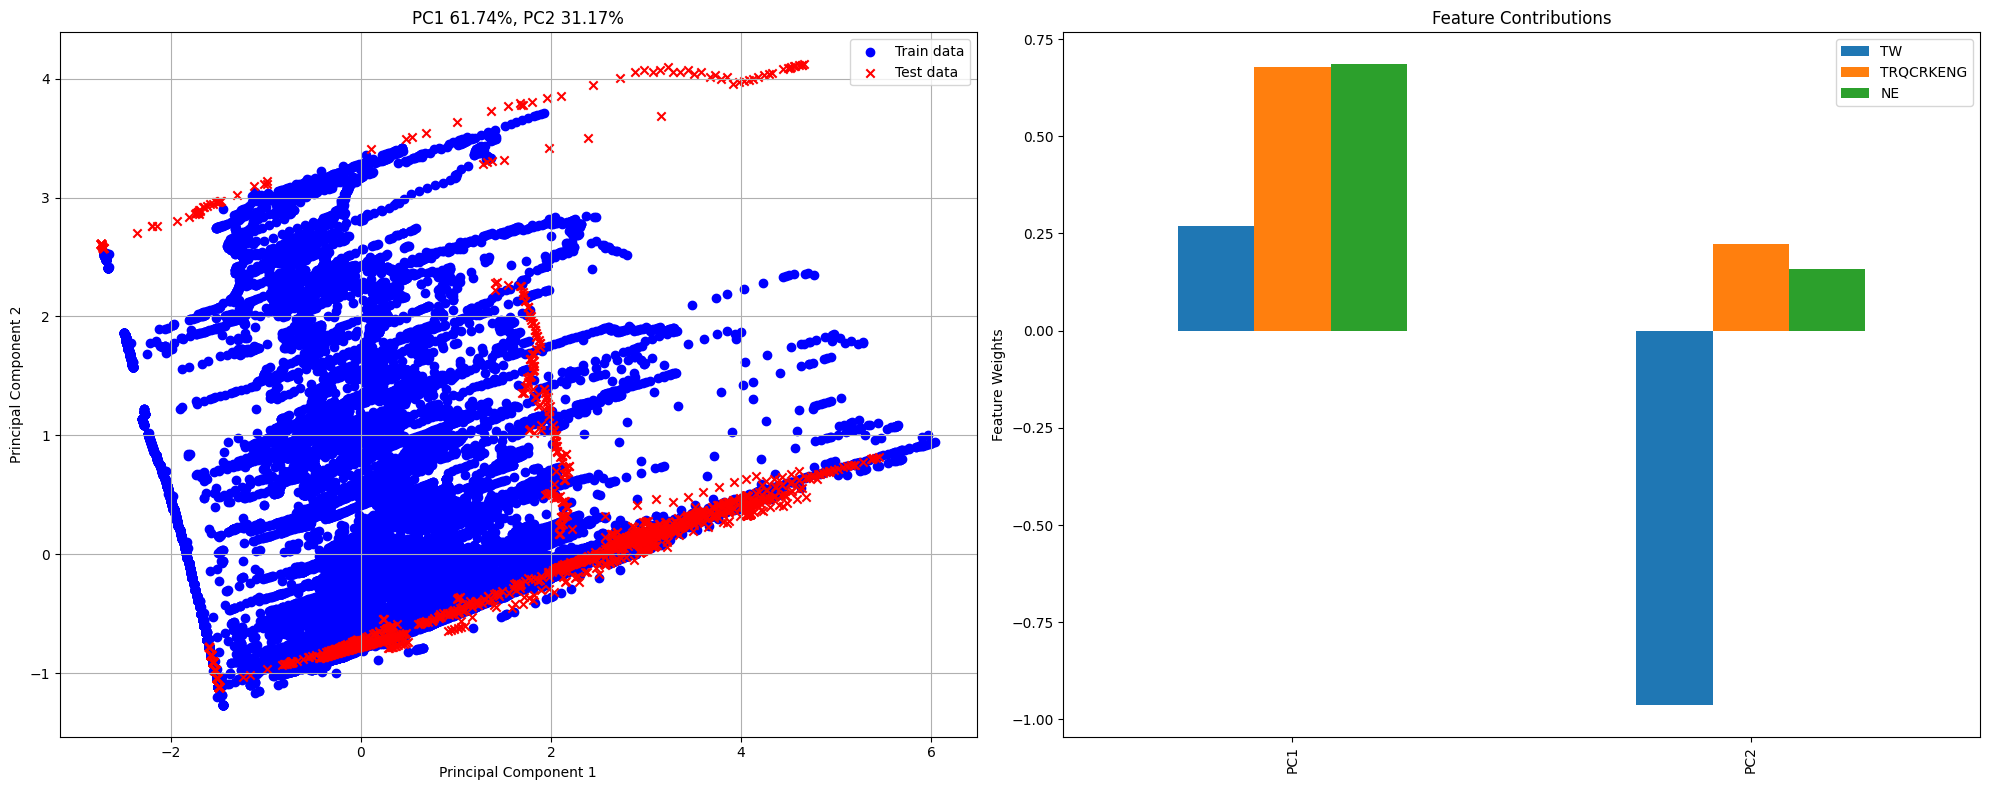

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

scaler = StandardScaler()
selected_train_data = scaler.fit_transform(train_data[selected_features])
selected_test_data = scaler.transform(test_data[selected_features])

# PCA
pca = PCA(n_components=0.9)
pca_train_data = pca.fit_transform(selected_train_data)
pca_test_data = pca.transform(selected_test_data)

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Visualize PCA
ax = axes[0]
ax.scatter(pca_train_data[:, 0], pca_train_data[:, 1], c='blue', marker='o', label='Train data')
ax.scatter(pca_test_data[:, 0], pca_test_data[:, 1], c='red', marker='x', label='Test data') 
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')

# 分散寄与度計算
explained_variance_ratio = pca.explained_variance_ratio_
explained_variance_ratio1 = explained_variance_ratio[0] * 100
explained_variance_ratio2 = explained_variance_ratio[1] * 100

ax.set_title(f'PC1 {explained_variance_ratio1:.2f}%, PC2 {explained_variance_ratio2:.2f}%')
ax.legend(loc='upper right')
ax.grid(True)

# feature contribution
components_df = pd.DataFrame(pca.components_, columns=selected_features, index=[f'PC{i+1}' for i in range(len(pca.components_))])

# Visualize
ax = axes[1]
components_df.iloc[:2, :].plot(kind='bar', ax=ax)
ax.set_title('Feature Contributions')
ax.set_ylabel('Feature Weights')

plt.tight_layout()
plt.show()


Epoch 1/20
140/140 [==============================] - 5s 8ms/step - loss: 0.9237
Epoch 2/20
140/140 [==============================] - 1s 8ms/step - loss: 0.8359
Epoch 3/20
140/140 [==============================] - 1s 8ms/step - loss: 0.7305
Epoch 4/20
140/140 [==============================] - 1s 8ms/step - loss: 0.6409
Epoch 5/20
140/140 [==============================] - 1s 8ms/step - loss: 0.5803
Epoch 6/20
140/140 [==============================] - 1s 8ms/step - loss: 0.5395
Epoch 7/20
140/140 [==============================] - 1s 8ms/step - loss: 0.5102
Epoch 8/20
140/140 [==============================] - 1s 8ms/step - loss: 0.4891
Epoch 9/20
140/140 [==============================] - 1s 8ms/step - loss: 0.4740
Epoch 10/20
140/140 [==============================] - 1s 8ms/step - loss: 0.4624
Epoch 11/20
140/140 [==============================] - 1s 8ms/step - loss: 0.4526
Epoch 12/20
140/140 [==============================] - 1s 8ms/step - loss: 0.4439
Epoch 13/20
140/140 [====

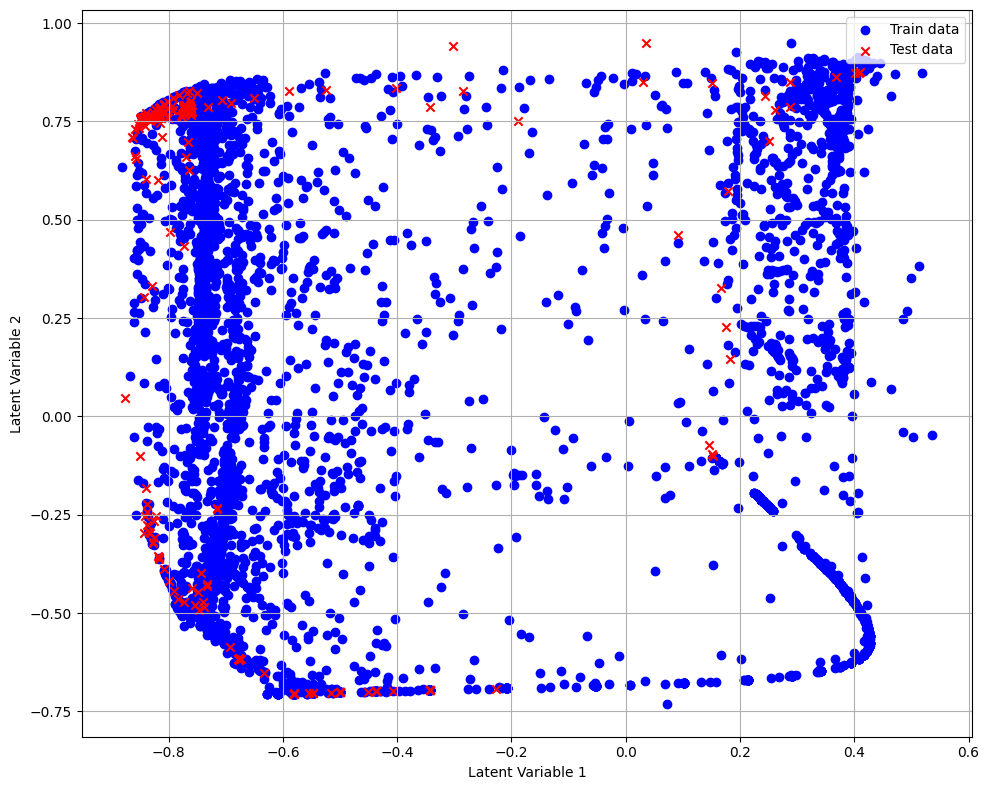

In [30]:
import tensorflow as tf
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector
from sklearn.preprocessing import StandardScaler
from scipy.spatial import Delaunay

# シードの設定
random_seed = 42
tf.random.set_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

# データスケーリング
scaler = StandardScaler()
selected_train_data = scaler.fit_transform(train_data[selected_features])
selected_test_data = scaler.transform(test_data[selected_features])

# ハイパーパラメータ
batch_size = 32
epochs = 20
unit_num = 2
sequence_length = 10  # シーケンス（ウィンドウ）長
n_features = selected_train_data.shape[1]

# タイムステップ数の計算
total_timesteps_train = selected_train_data.shape[0]
total_timesteps_test = selected_test_data.shape[0]

# ウィンドウ単位で切り捨てる
timesteps_train = (total_timesteps_train // sequence_length) * sequence_length
timesteps_test = (total_timesteps_test // sequence_length) * sequence_length

# ウィンドウ長に合わせてデータを切り詰める
reshape_train_data = selected_train_data[:timesteps_train, :]
reshape_test_data = selected_test_data[:timesteps_test, :]

# データをウィンドウに分割
reshape_train_data = reshape_train_data.reshape((-1, sequence_length, n_features))
reshape_test_data = reshape_test_data.reshape((-1, sequence_length, n_features))

# LSTM AutoEncoder アーキテクチャ
inputs = Input(shape=(sequence_length, n_features))
encoded = LSTM(unit_num)(inputs)
decoded = RepeatVector(sequence_length)(encoded)
decoded = LSTM(n_features, return_sequences=True)(decoded)

autoencoder = Model(inputs, decoded)

# モデルのコンパイルと訓練
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(reshape_train_data, reshape_train_data, epochs=epochs, batch_size=batch_size, shuffle=False)

# 次元削減
encoder = Model(inputs, encoded)
encoded_train_data = encoder.predict(reshape_train_data)
encoded_test_data = encoder.predict(reshape_test_data)

# Delaunay での凸包を計算
hull = Delaunay(encoded_train_data)

# 検証データが外挿かどうかを判定
test_points = np.array(encoded_test_data)
find_simplex_result = hull.find_simplex(test_points)

# 可視化
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(encoded_train_data[:, 0], encoded_train_data[:, 1], c='blue', marker='o', label='Train data')
ax.scatter(test_points[:, 0], test_points[:, 1], c='red', marker='x', label='Test data')
ax.set_xlabel('Latent Variable 1')
ax.set_ylabel('Latent Variable 2')
ax.legend(loc='upper right')
ax.grid(True)
plt.tight_layout()
plt.show()


Epoch 1/20
1398/1398 [==============================] - 15s 8ms/step - loss: 0.6473
Epoch 2/20
1398/1398 [==============================] - 11s 8ms/step - loss: 0.4277
Epoch 3/20
1398/1398 [==============================] - 11s 8ms/step - loss: 0.3654
Epoch 4/20
1398/1398 [==============================] - 11s 8ms/step - loss: 0.3242
Epoch 5/20
1398/1398 [==============================] - 11s 8ms/step - loss: 0.2977
Epoch 6/20
1398/1398 [==============================] - 11s 8ms/step - loss: 0.2800
Epoch 7/20
1398/1398 [==============================] - 11s 8ms/step - loss: 0.2665
Epoch 8/20
1398/1398 [==============================] - 11s 8ms/step - loss: 0.2565
Epoch 9/20
1398/1398 [==============================] - 11s 8ms/step - loss: 0.2490
Epoch 10/20
1398/1398 [==============================] - 11s 8ms/step - loss: 0.2437
Epoch 11/20
1398/1398 [==============================] - 11s 8ms/step - loss: 0.2401
Epoch 12/20
1398/1398 [==============================] - 11s 8ms/step - lo

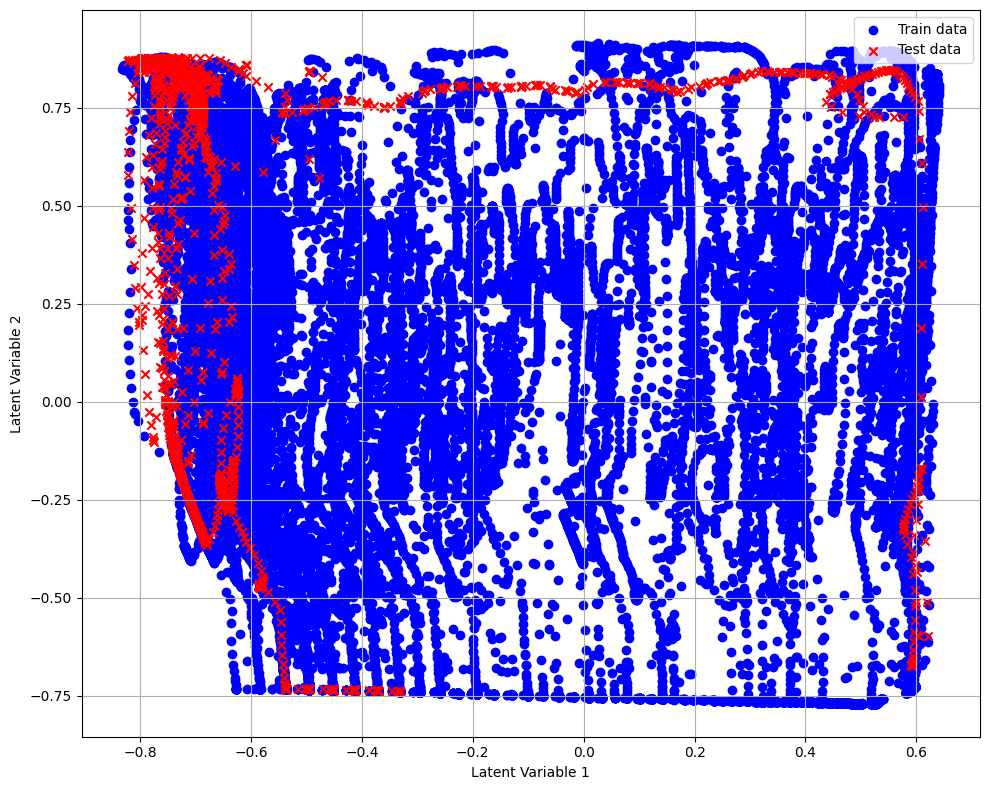

In [31]:
import tensorflow as tf
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector
from sklearn.preprocessing import StandardScaler
from scipy.spatial import Delaunay

# シードの設定
random_seed = 42
tf.random.set_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

# データスケーリング
scaler = StandardScaler()
selected_train_data = scaler.fit_transform(train_data[selected_features])
selected_test_data = scaler.transform(test_data[selected_features])

# ハイパーパラメータ
batch_size = 32
epochs = 20
unit_num = 2
sequence_length = 10  # シーケンス（ウィンドウ）長
n_features = selected_train_data.shape[1]

# ウィンドウを重複させてシーケンスデータを作成
def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length + 1):
        sequences.append(data[i:i + sequence_length, :])
    return np.array(sequences)

# シーケンスデータ作成
reshape_train_data = create_sequences(selected_train_data, sequence_length)
reshape_test_data = create_sequences(selected_test_data, sequence_length)

# LSTM AutoEncoder アーキテクチャ
inputs = Input(shape=(sequence_length, n_features))
encoded = LSTM(unit_num)(inputs)
decoded = RepeatVector(sequence_length)(encoded)
decoded = LSTM(n_features, return_sequences=True)(decoded)

autoencoder = Model(inputs, decoded)

# モデルのコンパイルと訓練
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(reshape_train_data, reshape_train_data, epochs=epochs, batch_size=batch_size, shuffle=False)

# 次元削減
encoder = Model(inputs, encoded)
encoded_train_data = encoder.predict(reshape_train_data)
encoded_test_data = encoder.predict(reshape_test_data)

# Delaunay での凸包を計算
hull = Delaunay(encoded_train_data)

# 検証データが外挿かどうかを判定
test_points = np.array(encoded_test_data)
find_simplex_result = hull.find_simplex(test_points)

# 可視化
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(encoded_train_data[:, 0], encoded_train_data[:, 1], c='blue', marker='o', label='Train data')
ax.scatter(test_points[:, 0], test_points[:, 1], c='red', marker='x', label='Test data')
ax.set_xlabel('Latent Variable 1')
ax.set_ylabel('Latent Variable 2')
ax.legend(loc='upper right')
ax.grid(True)
plt.tight_layout()
plt.show()


In [15]:
import tensorflow as tf
import random
import plotly.graph_objects as go
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.spatial import Delaunay

# Seed for reproducibility
random_seed = 42
tf.random.set_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

# Data scaling
scaler = StandardScaler()

# Assume train_data and selected_features are defined
selected_train_data = scaler.fit_transform(train_data[selected_features])
selected_test_data = scaler.transform(test_data[selected_features])

# Hyperparameters
batch_size = 30
epochs = 20
unit_num = 3

n_features = selected_train_data.shape[1]

# Calculate total timesteps
total_timesteps_train = selected_train_data.shape[0]
total_timesteps_test = selected_test_data.shape[0]

# Truncate data for equal division
timesteps_train = total_timesteps_train // batch_size * batch_size
timesteps_test = total_timesteps_test // batch_size * batch_size

# Truncate and reshape data
reshape_train_data = selected_train_data[:timesteps_train, :]
reshape_test_data = selected_test_data[:timesteps_test, :]

reshape_train_data = reshape_train_data.reshape((batch_size, timesteps_train // batch_size, n_features))
reshape_test_data = reshape_test_data.reshape((batch_size, timesteps_test // batch_size, n_features))

# LSTM AutoEncoder architecture
inputs = tf.keras.layers.Input(shape=(timesteps_train // batch_size, n_features))
encoded = tf.keras.layers.LSTM(unit_num, return_sequences=False)(inputs)
decoded = tf.keras.layers.RepeatVector(timesteps_train // batch_size)(encoded)
decoded = tf.keras.layers.LSTM(n_features, return_sequences=True)(decoded)

autoencoder = tf.keras.models.Model(inputs, decoded)

# Separate encoder and decoder
encoder = tf.keras.models.Model(inputs, encoded)
decoder_input = tf.keras.layers.Input(shape=(timesteps_train // batch_size, unit_num))
decoder_output = tf.keras.layers.LSTM(n_features, return_sequences=True)(decoder_input)
decoder = tf.keras.models.Model(decoder_input, decoder_output)

# Compile and fit model
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(reshape_train_data, reshape_train_data, epochs=epochs, batch_size=batch_size, shuffle=False)

# Dimensionality reduction
encoded_train_data = encoder.predict(reshape_train_data)
encoded_test_data = encoder.predict(reshape_test_data)

# Reshape encoded data for the decoder
reshaped_encoded_train_data = np.repeat(encoded_train_data[:, np.newaxis, :], timesteps_train // batch_size, axis=1)
reshaped_encoded_test_data = np.repeat(encoded_test_data[:, np.newaxis, :], timesteps_test // batch_size, axis=1)

# Decoding to original dimensions
decoded_train_data = decoder.predict(reshaped_encoded_train_data)
decoded_test_data = decoder.predict(reshaped_encoded_test_data)

# Reshape decoded data to original shape
reshaped_decoded_train_data = decoded_train_data.reshape(-1, n_features)
reshaped_decoded_test_data = decoded_test_data.reshape(-1, n_features)

# ここで標準化を逆変換
reshaped_decoded_train_data = scaler.inverse_transform(reshaped_decoded_train_data)
reshaped_decoded_test_data = scaler.inverse_transform(reshaped_decoded_test_data)



# Delaunay triangulation for outlier detection
hull = Delaunay(encoded_train_data)
test_points = encoded_test_data
is_outlier = hull.find_simplex(test_points) < 0

# is_outlier配列の次元をreshaped_decoded_test_dataに合わせる
expanded_is_outlier = np.repeat(is_outlier, timesteps_test // batch_size)

# 3D Visualization using Plotly
fig = go.Figure()

# Training data points
fig.add_trace(go.Scatter3d(x=reshaped_decoded_train_data[:, 0], y=reshaped_decoded_train_data[:, 1], z=reshaped_decoded_train_data[:, 2],
                          mode='markers', marker=dict(size=5, color='blue'), name='Train Data'))

# Test data points (inliers)
fig.add_trace(go.Scatter3d(x=reshaped_decoded_test_data[~expanded_is_outlier, 0], 
                           y=reshaped_decoded_test_data[~expanded_is_outlier, 1], 
                           z=reshaped_decoded_test_data[~expanded_is_outlier, 2],
                           mode='markers', marker=dict(size=5, color='green'), name='Test Inliers'))

# Test data points (outliers)
fig.add_trace(go.Scatter3d(x=reshaped_decoded_test_data[expanded_is_outlier, 0], 
                           y=reshaped_decoded_test_data[expanded_is_outlier, 1], 
                           z=reshaped_decoded_test_data[expanded_is_outlier, 2],
                           mode='markers', marker=dict(size=5, color='red'), name='Test Outliers'))

fig.write_html("3D_plot.html")

Epoch 1/20
1/1 [==============================] - 2s 2s/step - loss: 1.0645
Epoch 2/20
1/1 [==============================] - 0s 326ms/step - loss: 1.0625
Epoch 3/20
1/1 [==============================] - 0s 314ms/step - loss: 1.0606
Epoch 4/20
1/1 [==============================] - 0s 317ms/step - loss: 1.0587
Epoch 5/20
1/1 [==============================] - 0s 319ms/step - loss: 1.0569
Epoch 6/20
1/1 [==============================] - 0s 321ms/step - loss: 1.0550
Epoch 7/20
1/1 [==============================] - 0s 326ms/step - loss: 1.0532
Epoch 8/20
1/1 [==============================] - 0s 321ms/step - loss: 1.0514
Epoch 9/20
1/1 [==============================] - 0s 314ms/step - loss: 1.0497
Epoch 10/20
1/1 [==============================] - 0s 317ms/step - loss: 1.0480
Epoch 11/20
1/1 [==============================] - 0s 321ms/step - loss: 1.0463
Epoch 12/20
1/1 [==============================] - 0s 316ms/step - loss: 1.0447
Epoch 13/20
1/1 [==============================] - 0

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Input, RepeatVector
from autokeras import KerasTuner 

def reshape_data(data, timesteps=10):
    reshaped_data = []
    for i in range(len(data) - timesteps):
        reshaped_data.append(data[i:i + timesteps])
    return np.array(reshaped_data)

# 例として過去10タイムステップを用います
timesteps = 10
reshaped_train_data = reshape_data(selected_train_data, timesteps)
reshaped_test_data = reshape_data(selected_test_data, timesteps)


n_features = reshaped_train_data.shape[2]

def build_model(hp):
    inputs = Input(shape=(timesteps, n_features))
    encoded = LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32))(inputs)
    decoded = RepeatVector(timesteps)(encoded)
    decoded = LSTM(n_features, return_sequences=True)(decoded)
    
    autoencoder = Model(inputs, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    
    return autoencoder


tuner = KerasTuner(
    build_model,
    objective='val_loss',
    max_trials=10,
    directory='autoencoder_tuning'
)

tuner.search(reshaped_train_data, reshaped_train_data,
             epochs=10,
             validation_split=0.2)


best_model = tuner.get_best_models(num_models=1)[0]
predicted_test_data = best_model.predict(reshaped_test_data)

# データを元のスケールに戻す
predicted_test_data = scaler.inverse_transform(predicted_test_data[:, 0, :])


# サンプルコード: 最初の３特徴量に対する3Dプロット
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(predicted_test_data[:, 0], predicted_test_data[:, 1], predicted_test_data[:, 2])
plt.show()


ImportError: cannot import name 'KerasTuner' from 'autokeras' (c:\Users\flapl\anaconda3\envs\myenv\lib\site-packages\autokeras\__init__.py)

For alpha=0, number of outsider_test_indices: 115
For alpha=0, number of boundary_train_indices: 199
For alpha=1, number of outsider_test_indices: 637
For alpha=1, number of boundary_train_indices: 2758
For alpha=2, number of outsider_test_indices: 643
For alpha=2, number of boundary_train_indices: 3345
For alpha=3, number of outsider_test_indices: 649
For alpha=3, number of boundary_train_indices: 3498


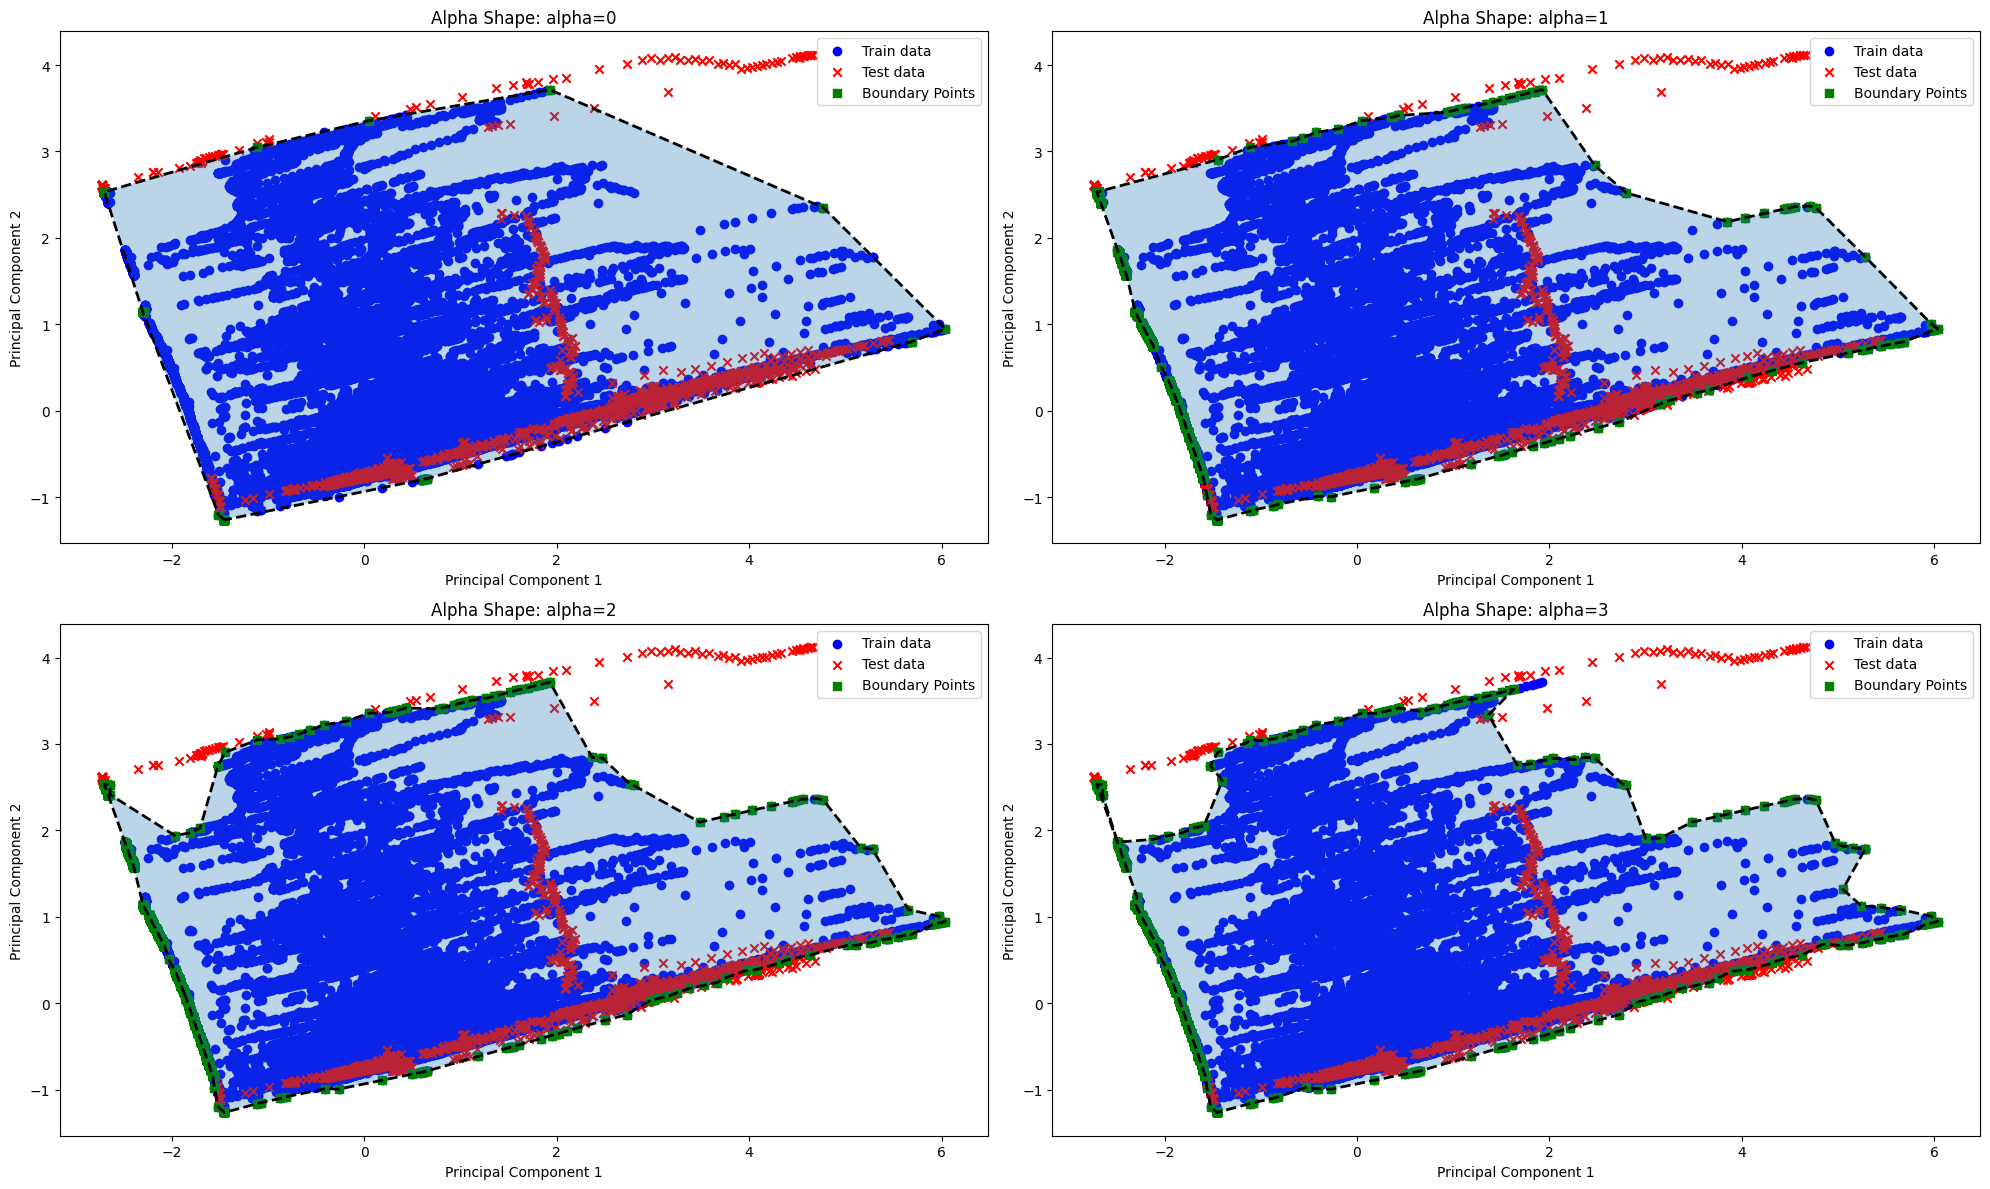

In [4]:
from shapely.geometry import MultiPoint, Point, shape
from alphashape import alphashape

# alpha_shape外形に対しpointとの距離がthresholdよりも小さければTrueを返す
def is_near_boundary(point, alpha_shape, threshold=1e-5):
    point = Point(point)
    return alpha_shape.boundary.distance(point) < threshold

# Initialize
outsider_test_points = {}
boundary_train_points = {}
original_boundary_train_points = {}
original_outsider_test_points = {}


fig, axes = plt.subplots(2, 2, figsize=(20, 12))

for i, alpha_value in enumerate(range(0, 4)):
    ax = axes[i//2, i%2]
    alpha_shape = alphashape(pca_train_data, alpha=alpha_value)
    
    # outside : alpha shape
    outsider_test_indices = [not alpha_shape.contains(Point(point)) for point in pca_test_data]
    outsider_test_points[alpha_value] = pca_test_data[np.where(outsider_test_indices)]
    
    # boundary : alpha shape
    boundary_train_indices = [is_near_boundary(point, alpha_shape) for point in pca_train_data]
    boundary_train_points[alpha_value] = pca_train_data[np.where(boundary_train_indices)]
    
    print(f"For alpha={alpha_value}, number of outsider_test_indices: {np.sum(outsider_test_indices)}")
    print(f"For alpha={alpha_value}, number of boundary_train_indices: {np.sum(boundary_train_indices)}")

    # 元の特徴空間でのデータ
    original_boundary_train_indices = np.where(boundary_train_indices)[0]
    original_boundary_train_points[alpha_value] = scaler.inverse_transform(selected_train_data[original_boundary_train_indices])

    # 元の特徴空間でのデータ
    original_outsider_test_points[alpha_value] = test_data[selected_features].iloc[np.where(outsider_test_indices)[0]]

    # Plotting
    ax.scatter(pca_train_data[:, 0], pca_train_data[:, 1], c='blue', marker='o', label='Train data')
    ax.scatter(pca_test_data[:, 0], pca_test_data[:, 1], c='red', marker='x', label='Test data')
    ax.scatter(boundary_train_points[alpha_value][:, 0], boundary_train_points[alpha_value][:, 1], c='green', marker='s', label='Boundary Points')
    #ax.scatter(outsider_test_points[alpha_value][:, 0], outsider_test_points[alpha_value][:, 1], c='purple', marker='^', label='Outsider Test Points')

    if alpha_shape.geom_type == 'Polygon':
        ax.plot(*alpha_shape.exterior.xy, c='k', linestyle='--', lw=2)
        ax.fill(*alpha_shape.exterior.xy, alpha=0.3)
    elif alpha_shape.geom_type == 'MultiPolygon':
        for shape in alpha_shape:
            ax.plot(*shape.exterior.xy, c='k', linestyle='--', lw=2)
            ax.fill(*shape.exterior.xy, alpha=0.3)

    ax.set_title(f'Alpha Shape: alpha={alpha_value}')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.legend()

plt.tight_layout()
plt.show()


In [24]:
from scipy.spatial import ConvexHull, Delaunay
import plotly.graph_objects as go
import numpy as np

# Initial data
points = train_data[selected_features].to_numpy()

# Number of layers to remove
num_layers_to_remove = 0

# Remove layers iteratively
for _ in range(num_layers_to_remove):
    hull = ConvexHull(points)
    points = np.delete(points, hull.vertices, axis=0)

# Final Convex Hull after removing layers
final_hull = ConvexHull(points)
final_boundary_points = points[final_hull.vertices, :]

# Apply Delaunay triangulation with the final boundary points to find outsider test points
test_points = test_data[selected_features].to_numpy()
deln = Delaunay(final_boundary_points)
is_inside = deln.find_simplex(test_points) >= 0
outsider_test_points = test_points[~is_inside]

# Plotting
fig = go.Figure()

# Original train data points
fig.add_trace(go.Scatter3d(x=train_data[selected_features].iloc[:, 0],
                           y=train_data[selected_features].iloc[:, 1],
                           z=train_data[selected_features].iloc[:, 2],
                           mode='markers',
                           marker=dict(size=4, color='green'),
                           name='Train Data'))

# Test data points
fig.add_trace(go.Scatter3d(x=test_data[selected_features].iloc[:, 0],
                           y=test_data[selected_features].iloc[:, 1],
                           z=test_data[selected_features].iloc[:, 2],
                           mode='markers',
                           marker=dict(size=4, color='red'),
                           name='Test Data'))

# Final boundary points after removing layers
fig.add_trace(go.Scatter3d(x=final_boundary_points[:, 0],
                           y=final_boundary_points[:, 1],
                           z=final_boundary_points[:, 2],
                           mode='markers',
                           marker=dict(size=4, color='blue'),
                           name=f'Boundary Points(remove {num_layers_to_remove}layer)'))

# Outsider test points
fig.add_trace(go.Scatter3d(x=outsider_test_points[:, 0],
                           y=outsider_test_points[:, 1],
                           z=outsider_test_points[:, 2],
                           mode='markers',
                           marker=dict(size=4, color='purple'),
                           name='Outsider Test Points'))

# Mesh for final Convex Hull
fig.add_trace(go.Mesh3d(x=points[:, 0],
                         y=points[:, 1],
                         z=points[:, 2],
                         i=final_hull.simplices[:, 0],
                         j=final_hull.simplices[:, 1],
                         k=final_hull.simplices[:, 2],
                         opacity=0.4,
                         color='orange'))

# Axis labels
fig.update_layout(scene=dict(xaxis_title=selected_features[0],
                             yaxis_title=selected_features[1],
                             zaxis_title=selected_features[2]),
                  title=f'3D_direct_Convex_Hull_Remove_{num_layers_to_remove}Layer.html')

# Save as HTML
fig.write_html(f"3D_direct_Convex_Hull_Remove_{num_layers_to_remove}Layer.html")


In [9]:
## PCA空間で外挿境界定義⇒高次元にMapping⇒convex_hull

import plotly.graph_objects as go
from scipy.spatial import ConvexHull

fig = go.Figure()
alpha_value = 3

# Add scatter plot for original train data points
fig.add_trace(go.Scatter3d(x=train_data[selected_features].iloc[:, 0],
                           y=train_data[selected_features].iloc[:, 1],
                           z=train_data[selected_features].iloc[:, 2],
                           mode='markers',
                           marker=dict(size=4, color='green'),
                           name='Train Data'))

# Add scatter plot for original test data points
fig.add_trace(go.Scatter3d(x=test_data[selected_features].iloc[:, 0],
                           y=test_data[selected_features].iloc[:, 1],
                           z=test_data[selected_features].iloc[:, 2],
                           mode='markers',
                           marker=dict(size=4, color='red'),
                           name='Test Data'))

# Add scatter plot for original_boundary_train_points
fig.add_trace(go.Scatter3d(x=original_boundary_train_points[alpha_value][:, 0],
                           y=original_boundary_train_points[alpha_value][:, 1],
                           z=original_boundary_train_points[alpha_value][:, 2],
                           mode='markers',
                           marker=dict(size=4, color='blue'),
                           name='Boundary Points'))

# Calculate Convex Hull for original_boundary_train_points
boundary_points = original_boundary_train_points[alpha_value]
hull = ConvexHull(boundary_points)

# Add mesh for Convex Hull
fig.add_trace(go.Mesh3d(x=boundary_points[:, 0],
                         y=boundary_points[:, 1],
                         z=boundary_points[:, 2],
                         i=hull.simplices[:, 0],
                         j=hull.simplices[:, 1],
                         k=hull.simplices[:, 2],
                         opacity=0.4,
                         color='orange',
                         name='Convex Hull'))

# Add scatter plot for original_outsider_test_points
fig.add_trace(go.Scatter3d(x=original_outsider_test_points[alpha_value].iloc[:, 0],
                           y=original_outsider_test_points[alpha_value].iloc[:, 1],
                           z=original_outsider_test_points[alpha_value].iloc[:, 2],
                           mode='markers',
                           marker=dict(size=4, color='purple'),
                           name='Outsider Test Points'))

# Set axis label
fig.update_layout(scene=dict(xaxis_title=selected_features[0],
                             yaxis_title=selected_features[1],
                             zaxis_title=selected_features[2]),
                  title=f'3D_PCA-mapping_alpha={alpha_value}')

# Save & Show
fig.write_html(f"3D_PCA-mapping_alpha={alpha_value}.html")
#fig.show()


In [ ]:
import numpy as np
from scipy.spatial import ConvexHull, Delaunay
import plotly.graph_objects as go
import alphashape

# ランダムな3次元データセットを生成
np.random.seed(0)
points = np.random.rand(50, 3)

# Delaunay三角分割
delaunay = Delaunay(points)
delaunay_triangles = delaunay.simplices

# Convex Hull
convex_hull = ConvexHull(points)
convex_hull_simplices = convex_hull.simplices

# Scatter plot for original points
scatter = go.Scatter3d(x=points[:, 0], y=points[:, 1], z=points[:, 2], 
                       mode='markers', marker=dict(size=5, color='red'))

# Delaunay三角分割の描画
fig_delaunay = go.Figure(data=[
    go.Mesh3d(x=points[:, 0], y=points[:, 1], z=points[:, 2], 
              i=delaunay_triangles[:, 0], j=delaunay_triangles[:, 1], k=delaunay_triangles[:, 2], opacity=0.5),
    scatter  # original points
])
fig_delaunay.write_html("delaunay.html")

# Convex Hullの描画
fig_convex_hull = go.Figure(data=[
    go.Mesh3d(x=points[:, 0], y=points[:, 1], z=points[:, 2], 
              i=convex_hull_simplices[:, 0], j=convex_hull_simplices[:, 1], k=convex_hull_simplices[:, 2], opacity=0.5),
    scatter  # original points
])
fig_convex_hull.write_html("convex_hull.html")


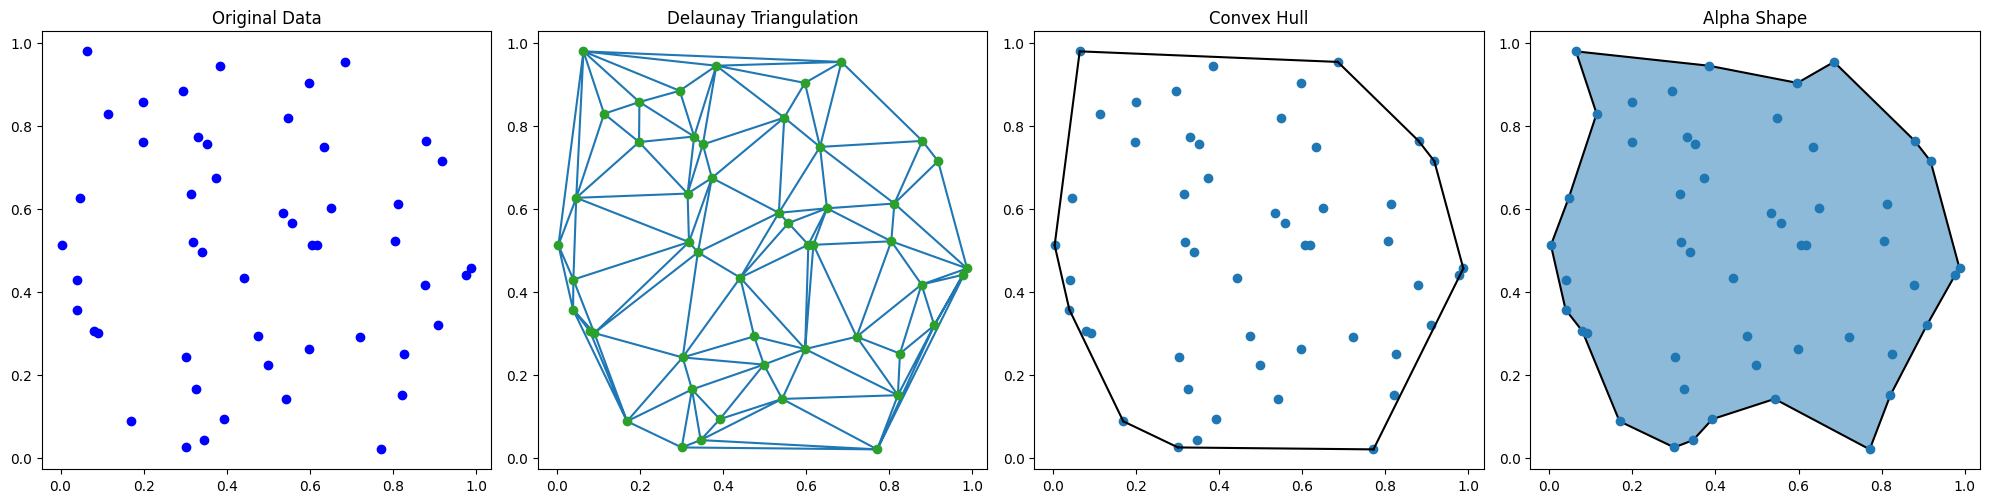

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay, ConvexHull
from alphashape import alphashape
from shapely.geometry import MultiPoint

# ランダムな2次元データセットを生成
np.random.seed(10)
points = np.random.rand(50, 2)

# Delaunay三角分割
delaunay = Delaunay(points)
delaunay_triangles = delaunay.simplices

# Convex Hull
convex_hull = ConvexHull(points)

# Alpha Shape
alpha_shape = alphashape(points, alpha=5)

# 可視化
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# 元のデータ
axes[0].scatter(points[:, 0], points[:, 1], c='blue')
axes[0].set_title('Original Data')

# Delaunay三角分割
axes[1].triplot(points[:, 0], points[:, 1], delaunay_triangles)
axes[1].plot(points[:, 0], points[:, 1], 'o')
axes[1].set_title('Delaunay Triangulation')

# Convex Hull
axes[2].plot(points[:, 0], points[:, 1], 'o')
for simplex in convex_hull.simplices:
    axes[2].plot(convex_hull.points[simplex, 0], convex_hull.points[simplex, 1], 'k-')
axes[2].set_title('Convex Hull')

# Alpha Shape
axes[3].plot(*alpha_shape.exterior.xy, c='k')
axes[3].fill(*alpha_shape.exterior.xy, alpha=0.5)
axes[3].plot(points[:, 0], points[:, 1], 'o')
axes[3].set_title('Alpha Shape')

for ax in axes:
    ax.set_aspect('equal', 'box')

plt.tight_layout()
plt.show()


In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from umap import UMAP
import matplotlib.pyplot as plt
import pandas as pd

# Standardize the data
scaler = StandardScaler()
selected_train_data = scaler.fit_transform(train_data[selected_features])
selected_test_data = scaler.transform(test_data[selected_features])

# UMAP
umap = UMAP(n_neighbors=15, min_dist=0.1, n_components=2)
umap_train_data = umap.fit_transform(selected_train_data)
umap_test_data = umap.transform(selected_test_data)

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Visualize UMAP
ax = axes[0]
ax.scatter(umap_train_data[:, 0], umap_train_data[:, 1], c='blue', marker='o', label='Train data')
ax.scatter(umap_test_data[:, 0], umap_test_data[:, 1], c='red', marker='x', label='Test data') 
ax.set_xlabel('UMAP Dimension 1')
ax.set_ylabel('UMAP Dimension 2')
ax.set_title('UMAP Projection')
ax.legend(loc='upper right')
ax.grid(True)


ImportError: cannot import name 'UMAP' from 'umap' (c:\Users\flapl\anaconda3\envs\myenv\lib\site-packages\umap\__init__.py)